Clean data

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
df = pd.read_csv('data.csv')

In [38]:
df.head()

,month,credit_amount,credit_term (month),age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,bad_client_target
0,1,7000,12,39,male,Secondary special education,Cell phones,0,2,21000,Another,0,0,0
1,1,19000,6,20,male,Secondary special education,Household appliances,1,2,17000,Another,3,1,0
2,1,29000,12,23,female,Secondary special education,Household appliances,0,2,31000,Another,2,0,0
3,1,10000,12,30,male,Secondary special education,Cell phones,1,2,31000,Unmarried,3,1,0
4,1,14500,12,25,female,Higher education,Cell phones,0,2,26000,Married,0,1,0


In [39]:
df.isnull().sum()
df.fillna(method='ffill', inplace=True)

C:\Users\tosca\AppData\Local\Temp\ipykernel_17908\2903114193.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


Encoder

In [40]:
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from category_encoders import TargetEncoder

In [41]:
le_sex = LabelEncoder()
df['sex'] = le_sex.fit_transform(df['sex'])

ordinal_encoder = OrdinalEncoder(categories=[['Incomplete secondary education', 'Secondary education', 'Secondary special education','Incomplete higher education', 'Higher education', 'PhD degree']]) 
df['education'] = ordinal_encoder.fit_transform(df[['education']])

target_encoder = TargetEncoder(cols=['product_type', 'family_status'], smoothing=1.0)
df[['product_type', 'family_status']] = target_encoder.fit_transform(df[['product_type', 'family_status']], df['bad_client_target'])

df.head()

,month,credit_amount,credit_term (month),age,sex,education,product_type,having_children_flg,region,income,family_status,phone_operator,is_client,bad_client_target
0,1,7000,12,39,1,2.0,0.226908,0,2,21000,0.104080,0,0,0
1,1,19000,6,20,1,2.0,0.076433,1,2,17000,0.104080,3,1,0
2,1,29000,12,23,0,2.0,0.076433,0,2,31000,0.104080,2,0,0
3,1,10000,12,30,1,2.0,0.226908,1,2,31000,0.115385,3,1,0
4,1,14500,12,25,0,4.0,0.226908,0,2,26000,0.139640,0,1,0


Verification de colinéarité

In [42]:
import numpy as np

correlation_matrix = df.corr()
for i in range(correlation_matrix.shape[0]):
    for j in range(correlation_matrix.shape[1]):
        if (correlation_matrix.iloc[i, j] == 1 or correlation_matrix.iloc[i, j] == -1) and i != j :
                print(f"Correlation of 1 or -1 found between '{correlation_matrix.index[i]}' and '{correlation_matrix.columns[j]}'")

Data set

In [43]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [44]:
X = df.drop(columns=['bad_client_target']) # Region and phone op are useless data but better benchmark with 
y = df['bad_client_target'] 

In [45]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) #divide dataset 80/20

Standardisation

In [46]:
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(X_train)  # Normalisation des données, (x-µ)/σ où : x = data, µ = moyenne de la colonne, σ = ecart-type de la colonne
X_test_scaled = scaler.transform(X_test)        # Donnée normalisé = même echelle = pas de donnée avec plus de poid

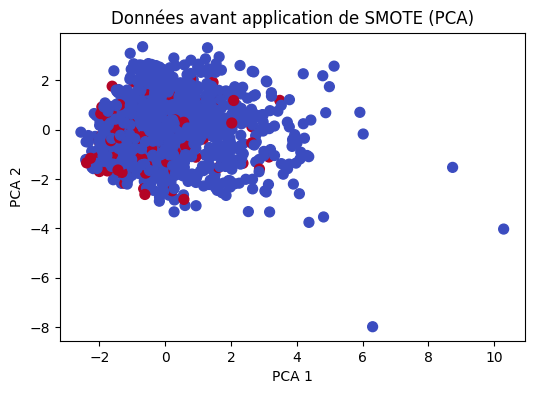

In [47]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Visualiser les données avant rééchantillonnage
plt.figure(figsize=(6, 4))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap='coolwarm', s=50)
plt.title("Données avant application de SMOTE (PCA)")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [48]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1378, 13)
y_train shape: (1378,)
X_test shape: (345, 13)
y_test shape: (345,)


Echantillonage des classes

In [49]:
from imblearn.over_sampling import SMOTE

In [50]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

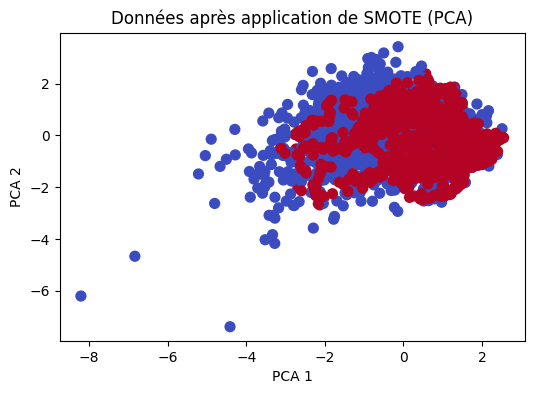

In [51]:
X_train_resampled_pca = pca.fit_transform(X_train_resampled)

# Visualiser les données rééchantillonnées après réduction de dimension
plt.figure(figsize=(6, 4))
plt.scatter(X_train_resampled_pca[:, 0], X_train_resampled_pca[:, 1], c=y_train_resampled, cmap='coolwarm', s=50)
plt.title("Données après application de SMOTE (PCA)")
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

GBM sans échantillonnage

In [52]:
from sklearn.ensemble import GradientBoostingClassifier

In [53]:
gbm = GradientBoostingClassifier(learning_rate= 0.01, max_depth= 3, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 150, subsample= 0.8)
gbm.fit(X_train_scaled, y_train)
y_pred_gbm = gbm.predict(X_test_scaled)

In [54]:
accuracy_gbm = accuracy_score(y_test, y_pred_gbm)
print(f'Précision : {accuracy_gbm:.2f}')

report_gbm = classification_report(y_test, y_pred_gbm)
print('Rapport de classification :\n', report_gbm)

Précision : 0.89
Rapport de classification :
               precision    recall  f1-score   support

           0       0.89      1.00      0.94       306
           1       0.50      0.03      0.05        39

    accuracy                           0.89       345
   macro avg       0.69      0.51      0.49       345
weighted avg       0.85      0.89      0.84       345



GBM avec échantillonnage

In [55]:
gbm_resampled = GradientBoostingClassifier(learning_rate= 0.01, max_depth= 7, min_samples_leaf= 1, min_samples_split= 10, n_estimators= 150, subsample= 0.8)
gbm_resampled.fit(X_train_resampled, y_train_resampled)
y_pred_gbm_resampled = gbm_resampled.predict(X_test_scaled)

In [56]:
accuracy_gbm_resampled = accuracy_score(y_test, y_pred_gbm_resampled)
print(f'Précision : {accuracy_gbm_resampled:.2f}')

report_gbm_resampled = classification_report(y_test, y_pred_gbm_resampled)
print('Rapport de classification :\n', report_gbm_resampled)

Précision : 0.78
Rapport de classification :
               precision    recall  f1-score   support

           0       0.92      0.82      0.87       306
           1       0.24      0.46      0.32        39

    accuracy                           0.78       345
   macro avg       0.58      0.64      0.59       345
weighted avg       0.85      0.78      0.80       345



RandomForest sans échantillonnage

In [57]:
from sklearn.ensemble import RandomForestClassifier

In [58]:
random_forest = RandomForestClassifier(n_estimators= 200, max_depth= 20, min_samples_split= 2, min_samples_leaf= 1, max_features= None, class_weight='balanced')
random_forest.fit(X_train_scaled, y_train)
y_pred_random_forest = random_forest.predict(X_test_scaled)

In [59]:
accuracy_random_forest = accuracy_score(y_test, y_pred_random_forest)
print(f'Précision : {accuracy_random_forest:.2f}')

report_random_forest = classification_report(y_test, y_pred_random_forest)
print('Rapport de classification :\n', report_random_forest)

Précision : 0.89
Rapport de classification :
               precision    recall  f1-score   support

           0       0.90      0.98      0.94       306
           1       0.50      0.15      0.24        39

    accuracy                           0.89       345
   macro avg       0.70      0.57      0.59       345
weighted avg       0.86      0.89      0.86       345



RandomForest avec échantillonnage

In [60]:
random_forest_resampled = RandomForestClassifier(n_estimators= 100, max_depth= 20, min_samples_split= 2, min_samples_leaf= 2, max_features= 'sqrt', class_weight='balanced')
random_forest_resampled.fit(X_train_resampled, y_train_resampled)
y_pred_random_forest_resampled = random_forest_resampled.predict(X_test_scaled)

In [62]:
accuracy_random_forest_resampled = accuracy_score(y_test, y_pred_random_forest_resampled)
print(f'Précision : {accuracy_random_forest_resampled:.2f}')

report_random_forest_resampled = classification_report(y_test, y_pred_random_forest_resampled)
print('Rapport de classification :\n', report_random_forest_resampled)

Précision : 0.83
Rapport de classification :
               precision    recall  f1-score   support

           0       0.91      0.91      0.91       306
           1       0.26      0.26      0.26        39

    accuracy                           0.83       345
   macro avg       0.58      0.58      0.58       345
weighted avg       0.83      0.83      0.83       345



KNN sans échantillonnage

In [63]:
from sklearn.neighbors import KNeighborsClassifier

In [64]:
model_knn = KNeighborsClassifier(n_neighbors=8, weights='distance', algorithm='kd_tree')
model_knn.fit(X_train_scaled, y_train)
y_pred_knn = model_knn.predict(X_test_scaled)   

In [65]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print(f'Précision : {accuracy_knn:.2f}')

report_knn = classification_report(y_test, y_pred_knn)
print('Rapport de classification :\n', report_knn)

Précision : 0.87
Rapport de classification :
               precision    recall  f1-score   support

           0       0.89      0.97      0.93       306
           1       0.25      0.08      0.12        39

    accuracy                           0.87       345
   macro avg       0.57      0.52      0.52       345
weighted avg       0.82      0.87      0.84       345



KNN avec échantillonnage

In [66]:
model_knn_ressempled = KNeighborsClassifier(n_neighbors=2, weights='distance', algorithm='kd_tree')
model_knn_ressempled.fit(X_train_resampled, y_train_resampled)
y_pred_knn_ressempled = model_knn_ressempled.predict(X_test_scaled)

In [67]:
accuracy_knn_resampled = accuracy_score(y_test, y_pred_knn_ressempled)
print(f'Précision : {accuracy_knn_resampled:.2f}')

report_knn_resampled = classification_report(y_test, y_pred_knn_ressempled)
print('Rapport de classification :\n', report_knn_resampled)

Précision : 0.77
Rapport de classification :
               precision    recall  f1-score   support

           0       0.90      0.83      0.86       306
           1       0.16      0.26      0.20        39

    accuracy                           0.77       345
   macro avg       0.53      0.54      0.53       345
weighted avg       0.81      0.77      0.79       345



Regression logistique sans échantillonnage

In [68]:
from sklearn.linear_model import LogisticRegression

In [82]:
model_reglogi = LogisticRegression(C= 0.001, class_weight= "balanced", max_iter= 100)
model_reglogi.fit(X_train_scaled, y_train)
y_pred_reglogi = model_reglogi.predict(X_test_scaled)

In [83]:
accuracy_reglogi = accuracy_score(y_test, y_pred_reglogi)
print(f'Précision : {accuracy_reglogi:.2f}')

report_reglogi = classification_report(y_test, y_pred_reglogi)
print('Rapport de classification :\n', report_reglogi)

Précision : 0.68
Rapport de classification :
               precision    recall  f1-score   support

           0       0.95      0.68      0.79       306
           1       0.22      0.72      0.34        39

    accuracy                           0.68       345
   macro avg       0.59      0.70      0.56       345
weighted avg       0.87      0.68      0.74       345



Regression logistique avec échantillonnage

In [89]:
model_reglogi_resampled = LogisticRegression(C= 0.01, class_weight= "balanced", max_iter= 100, penalty= 'l2', solver= 'liblinear')
model_reglogi_resampled.fit(X_train_resampled, y_train_resampled)
y_pred_reglogi_resampled = model_reglogi_resampled.predict(X_test_scaled)

In [90]:
accuracy_reglogi_resampled = accuracy_score(y_test, y_pred_reglogi_resampled)
print(f'Précision : {accuracy_reglogi_resampled:.2f}')

report_reglogi_resampled = classification_report(y_test, y_pred_reglogi_resampled)
print('Rapport de classification :\n', report_reglogi_resampled)

Précision : 0.66
Rapport de classification :
               precision    recall  f1-score   support

           0       0.94      0.67      0.78       306
           1       0.20      0.64      0.30        39

    accuracy                           0.66       345
   macro avg       0.57      0.65      0.54       345
weighted avg       0.85      0.66      0.72       345



Matrice de confusion

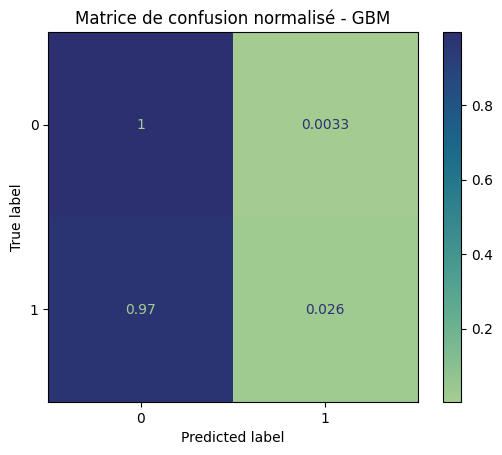

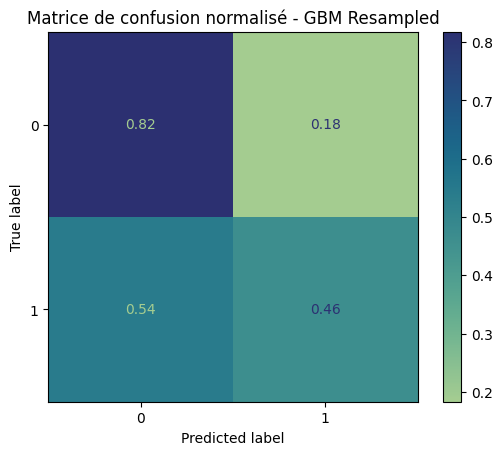

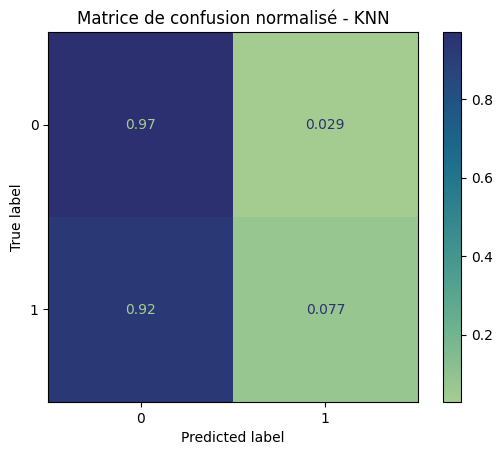

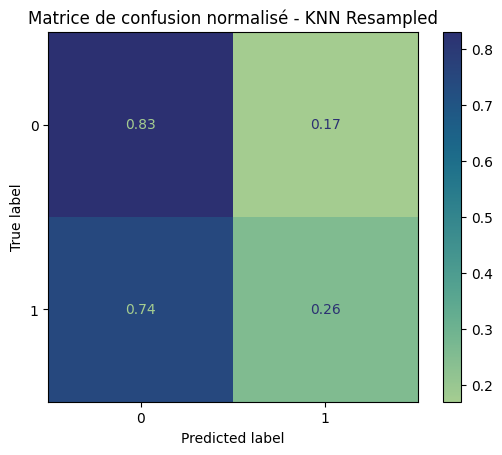

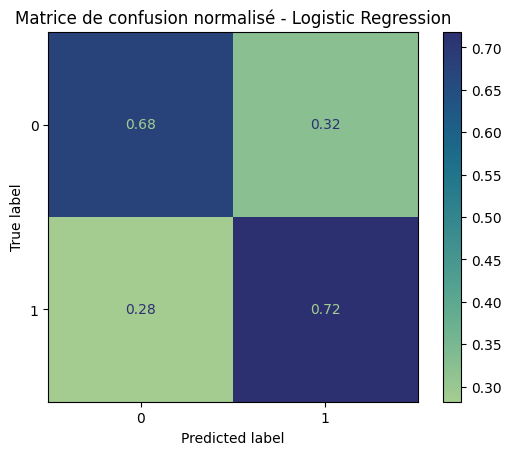

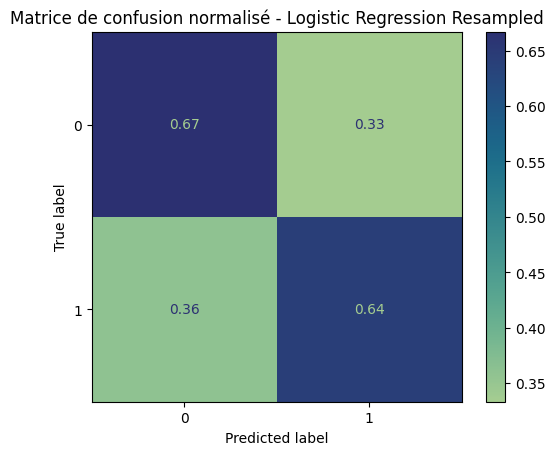

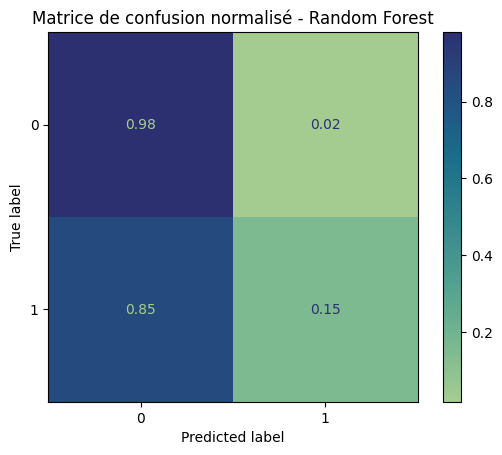

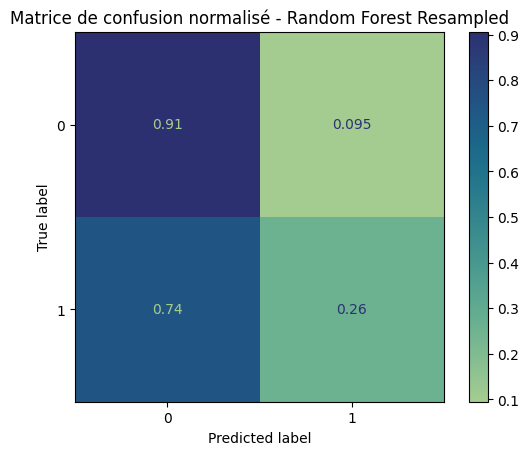

In [96]:
from sklearn.metrics import ConfusionMatrixDisplay

model_dict = {
    "GBM": gbm,
    "GBM Resampled": gbm_resampled,
    "KNN": model_knn,
    "KNN Resampled": model_knn_ressempled,
    "Logistic Regression": model_reglogi,
    "Logistic Regression Resampled": model_reglogi_resampled,
    "Random Forest": random_forest,
    "Random Forest Resampled": random_forest_resampled
}

for name, model in model_dict.items():
    ConfusionMatrixDisplay.from_estimator(model, X_test_scaled, y_test, normalize='true', cmap='crest')
    plt.title(f"Matrice de confusion normalisé - {name}")
    plt.show()


ROC

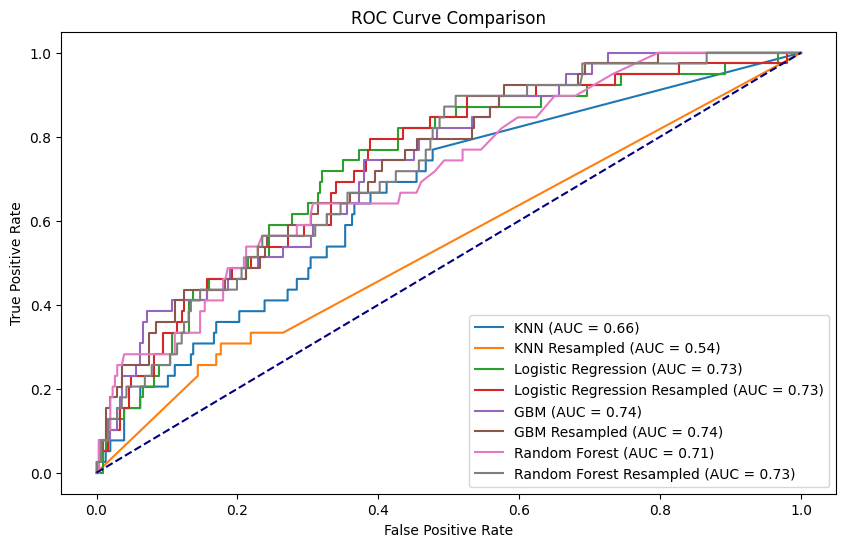

In [97]:
from sklearn.metrics import roc_curve, roc_auc_score

# Prédiction des probabilités pour chaque modèle
y_pred_proba_knn = model_knn.predict_proba(X_test_scaled)[:, 1]
y_pred_proba_knn_resampled = model_knn_ressempled.predict_proba(X_test_scaled)[:, 1]

y_pred_proba_reglogi = model_reglogi.predict_proba(X_test_scaled)[:, 1]
y_pred_proba_reglogi_resampled = model_reglogi_resampled.predict_proba(X_test_scaled)[:, 1]

y_pred_proba_gbm = gbm.predict_proba(X_test_scaled)[:, 1]
y_pred_proba_gbm_resampled = gbm_resampled.predict_proba(X_test_scaled)[:, 1]

y_pred_proba_forest = random_forest.predict_proba(X_test_scaled)[:, 1]
y_pred_proba_forest_resampled = random_forest_resampled.predict_proba(X_test_scaled)[:, 1]

# Calcul des courbes ROC pour chaque modèle
fpr_knn, tpr_knn, _ = roc_curve(y_test, y_pred_proba_knn)
fpr_knn_resampled, tpr_knn_resampled, _ = roc_curve(y_test, y_pred_proba_knn_resampled)

fpr_reglogi, tpr_reglogi, _ = roc_curve(y_test, y_pred_proba_reglogi)
fpr_reglogi_resampled, tpr_reglogi_resampled, _ = roc_curve(y_test, y_pred_proba_reglogi_resampled)

fpr_gbm, tpr_gbm, _ = roc_curve(y_test, y_pred_proba_gbm)
fpr_gbm_resampled, tpr_gbm_resampled, _ = roc_curve(y_test, y_pred_proba_gbm_resampled)

fpr_forest, tpr_forest, _ = roc_curve(y_test, y_pred_proba_forest)
fpr_forest_resampled, tpr_forest_resampled, _ = roc_curve(y_test, y_pred_proba_forest_resampled)

# Calcul des AUC pour chaque modèle
auc_knn = roc_auc_score(y_test, y_pred_proba_knn)
auc_knn_resampled = roc_auc_score(y_test, y_pred_proba_knn_resampled)

auc_reglogi = roc_auc_score(y_test, y_pred_proba_reglogi)
auc_reglogi_resampled = roc_auc_score(y_test, y_pred_proba_reglogi_resampled)

auc_gbm = roc_auc_score(y_test, y_pred_proba_gbm)
auc_gbm_resampled = roc_auc_score(y_test, y_pred_proba_gbm_resampled)

auc_forest = roc_auc_score(y_test, y_pred_proba_forest)
auc_forest_resampled = roc_auc_score(y_test, y_pred_proba_forest_resampled)

# Visualisation des courbes ROC
plt.figure(figsize=(10, 6))

# Tracer les courbes ROC pour chaque modèle
plt.plot(fpr_knn, tpr_knn, label=f'KNN (AUC = {auc_knn:.2f})')
plt.plot(fpr_knn_resampled, tpr_knn_resampled, label=f'KNN Resampled (AUC = {auc_knn_resampled:.2f})')

plt.plot(fpr_reglogi, tpr_reglogi, label=f'Logistic Regression (AUC = {auc_reglogi:.2f})')
plt.plot(fpr_reglogi_resampled, tpr_reglogi_resampled, label=f'Logistic Regression Resampled (AUC = {auc_reglogi_resampled:.2f})')

plt.plot(fpr_gbm, tpr_gbm, label=f'GBM (AUC = {auc_gbm:.2f})')
plt.plot(fpr_gbm_resampled, tpr_gbm_resampled, label=f'GBM Resampled (AUC = {auc_gbm_resampled:.2f})')

plt.plot(fpr_forest, tpr_forest, label=f'Random Forest (AUC = {auc_forest:.2f})')
plt.plot(fpr_forest_resampled, tpr_forest_resampled, label=f'Random Forest Resampled (AUC = {auc_forest_resampled:.2f})')

# Ligne diagonale représentant le hasard
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Légendes et titres
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')

# Afficher le graphique
plt.show()


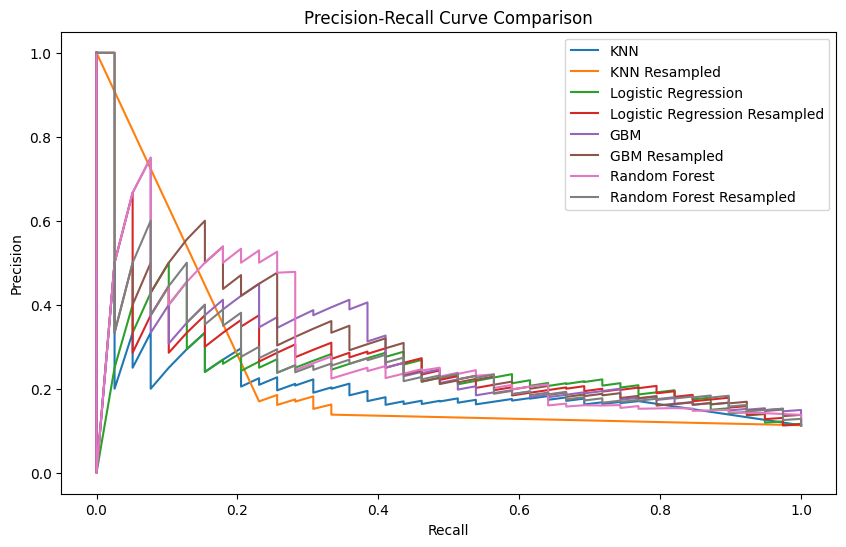

In [99]:
from sklearn.metrics import precision_recall_curve

# Courbe de précision-rappel pour chaque modèle
precision_knn, recall_knn, _ = precision_recall_curve(y_test, y_pred_proba_knn)
precision_knn_resampled, recall_knn_resampled, _ = precision_recall_curve(y_test, y_pred_proba_knn_resampled)

precision_reglogi, recall_reglogi, _ = precision_recall_curve(y_test, y_pred_proba_reglogi)
precision_reglogi_resampled, recall_reglogi_resampled, _ = precision_recall_curve(y_test, y_pred_proba_reglogi_resampled)

precision_gbm, recall_gbm, _ = precision_recall_curve(y_test, y_pred_proba_gbm)
precision_gbm_resampled, recall_gbm_resampled, _ = precision_recall_curve(y_test, y_pred_proba_gbm_resampled)

precision_forest, recall_forest, _ = precision_recall_curve(y_test, y_pred_proba_forest)
precision_forest_resampled, recall_forest_resampled, _ = precision_recall_curve(y_test, y_pred_proba_forest_resampled)

# Visualisation des courbes de précision-rappel
plt.figure(figsize=(10, 6))

# Tracer les courbes pour chaque modèle
plt.plot(recall_knn, precision_knn, label=f'KNN')
plt.plot(recall_knn_resampled, precision_knn_resampled, label=f'KNN Resampled')

plt.plot(recall_reglogi, precision_reglogi, label=f'Logistic Regression')
plt.plot(recall_reglogi_resampled, precision_reglogi_resampled, label=f'Logistic Regression Resampled')

plt.plot(recall_gbm, precision_gbm, label=f'GBM')
plt.plot(recall_gbm_resampled, precision_gbm_resampled, label=f'GBM Resampled')

plt.plot(recall_forest, precision_forest, label=f'Random Forest')
plt.plot(recall_forest_resampled, precision_forest_resampled, label=f'Random Forest Resampled')

# Légendes et titres
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve Comparison')
plt.legend(loc='upper right')

# Afficher le graphique
plt.show()


Importance des variables

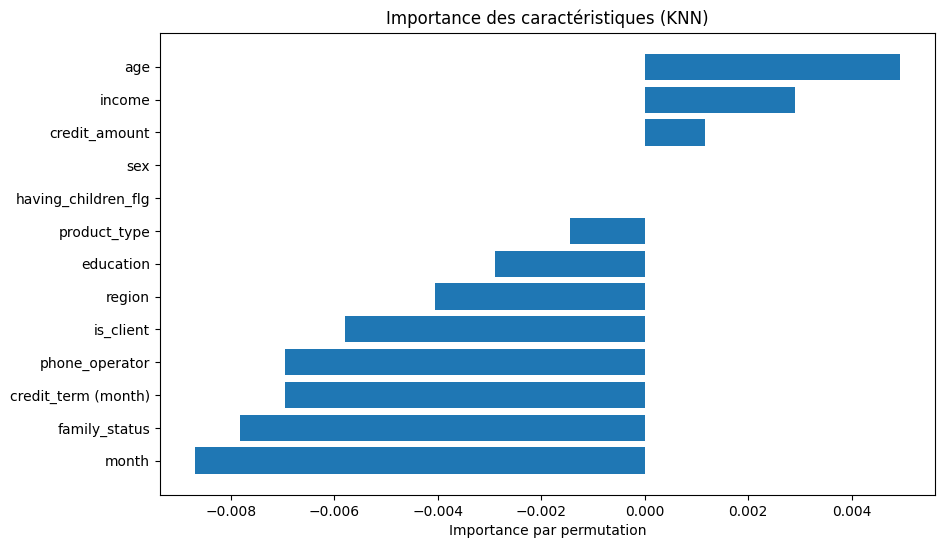

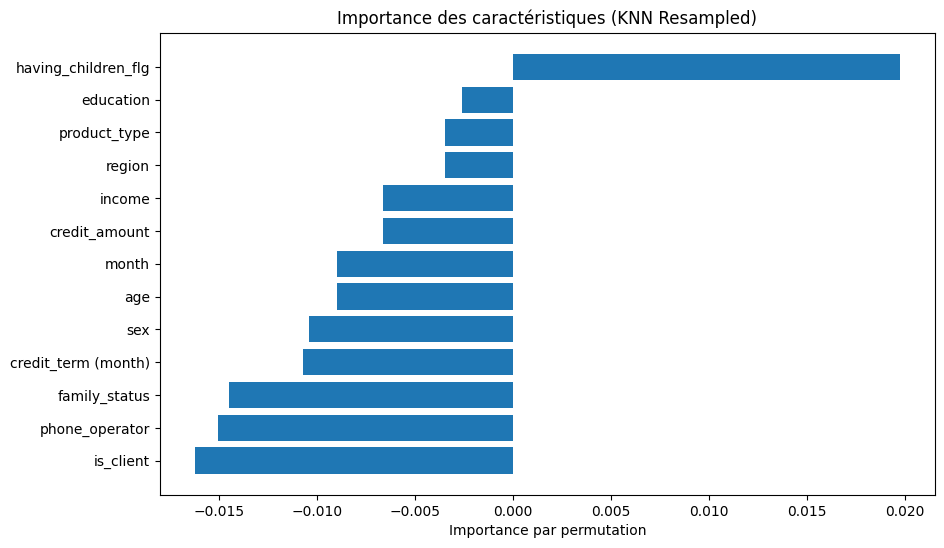

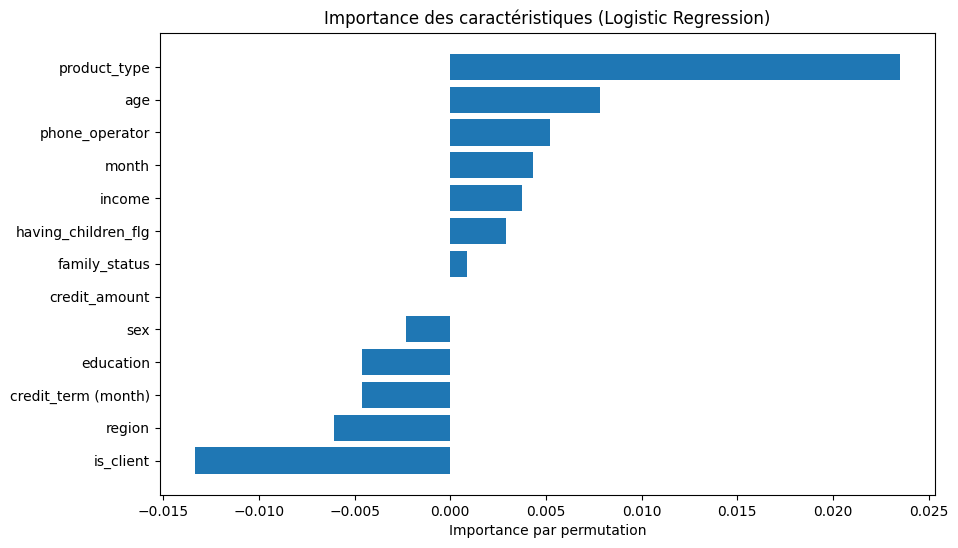

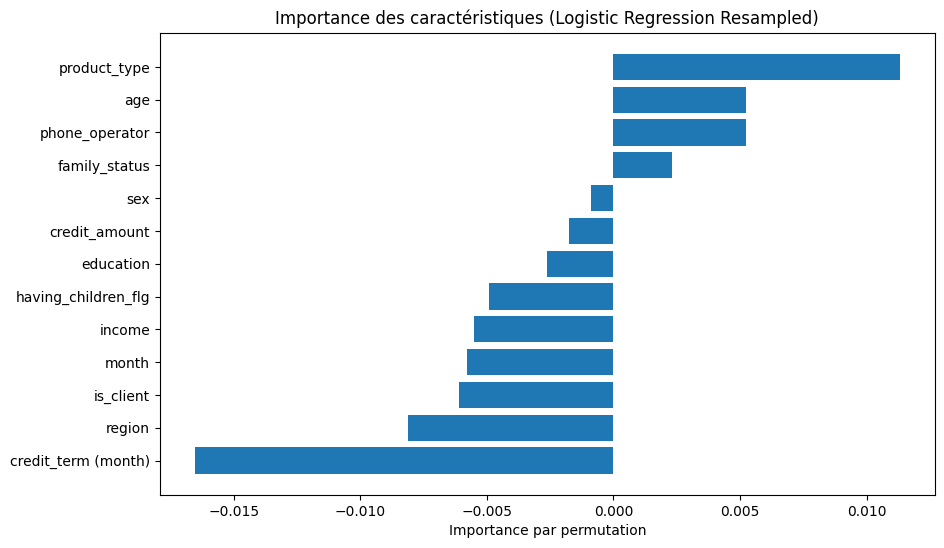

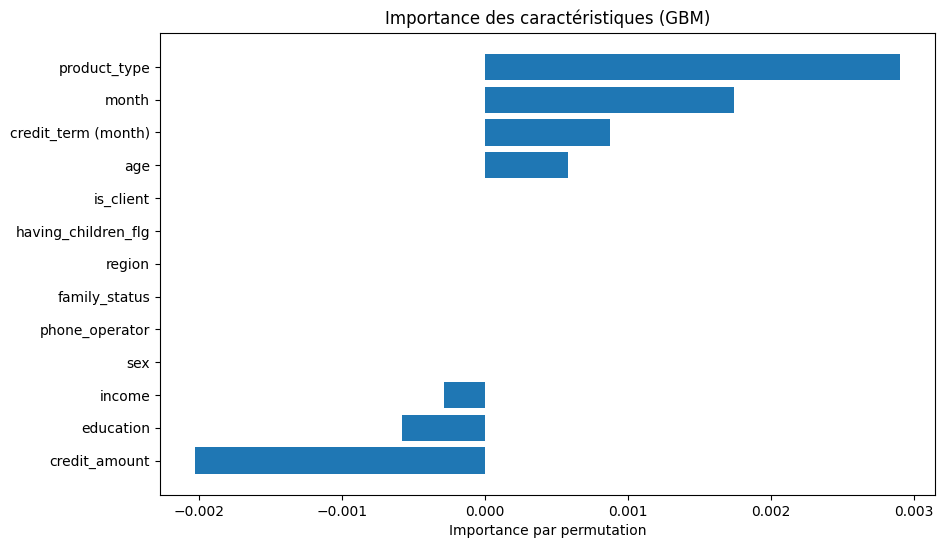

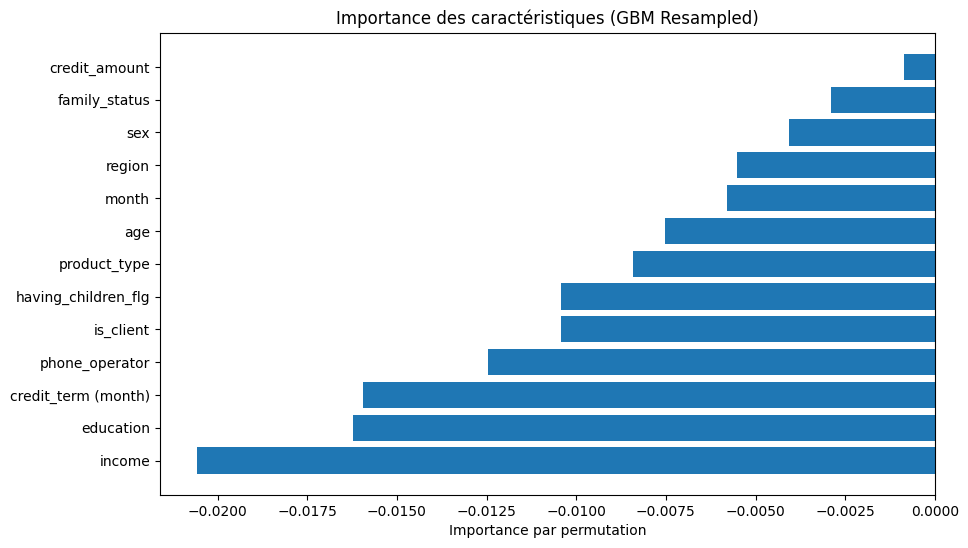

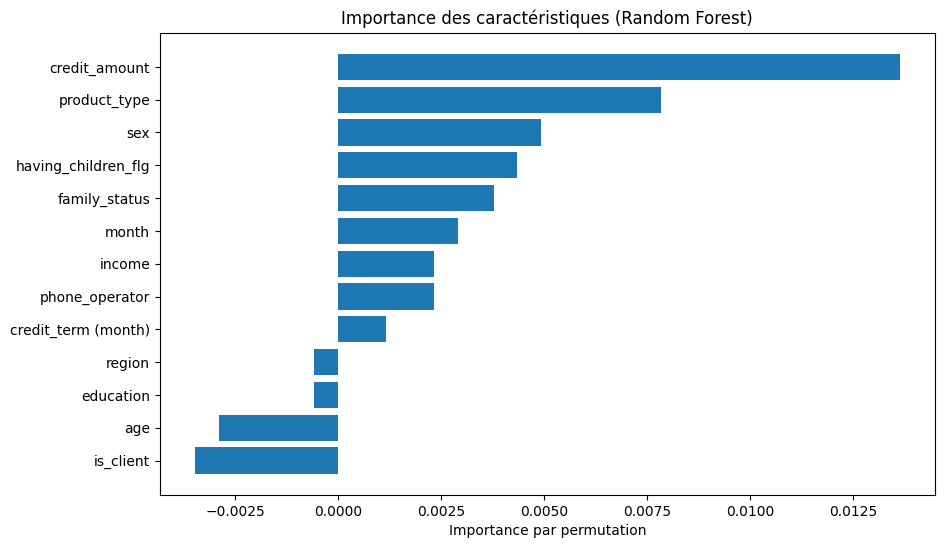

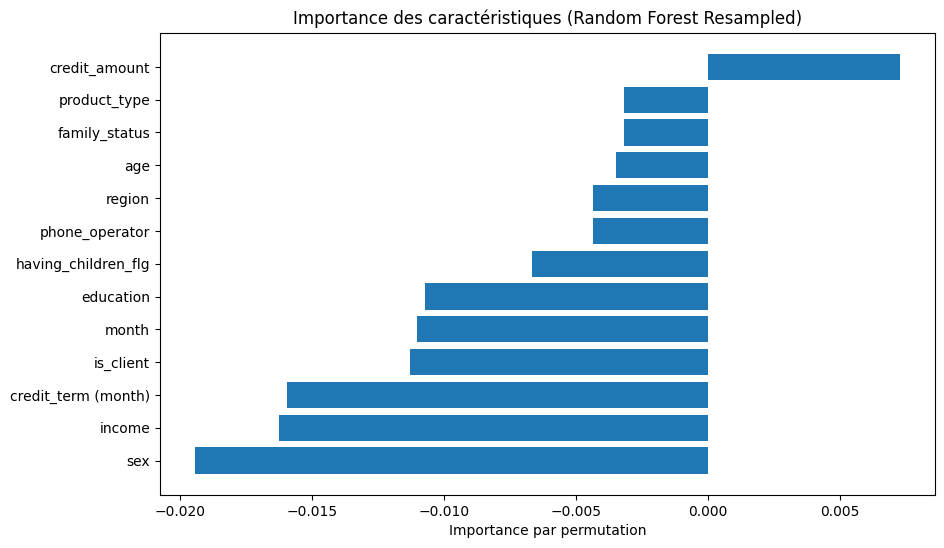

In [100]:
from sklearn.inspection import permutation_importance

# Calculer l'importance des caractéristiques par permutation pour chaque modèle
models = {
    "KNN": model_knn,
    "KNN Resampled": model_knn_ressempled,
    "Logistic Regression": model_reglogi,
    "Logistic Regression Resampled": model_reglogi_resampled,
    "GBM": gbm,
    "GBM Resampled": gbm_resampled,
    "Random Forest": random_forest,
    "Random Forest Resampled": random_forest_resampled
}

# Visualisation des importances pour chaque modèle
for model_name, model in models.items():
    result = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)

    # Extraire les moyennes des importances
    importance_means = result.importances_mean

    # Triez les caractéristiques par importance
    indices = np.argsort(importance_means)

    # Visualisation des importances des caractéristiques
    plt.figure(figsize=(10, 6))
    plt.barh(X_train.columns[indices], importance_means[indices])
    plt.xlabel("Importance par permutation")
    plt.title(f"Importance des caractéristiques ({model_name})")
    plt.show()
